In [ ]:
# > w1 = 2*pi*0.008; x1 = 0.35;
# > w2 = 2*pi*0.04;  x2 = 0.5;
# > w3 = 2*pi*0.05;  x3 = 0.5;
# >
# > % Slope of +3 from w1
# > wH = 0.008*(s^2/w1^2 + 2*x1/w1*s + 1)*(s/w1 + 1);
# > % Little bump from w2 to w3
# > wH = wH*(s^2/w2^2 + 2*x2/w2*s + 1)/(s^2/w3^2 + 2*x3/w3*s + 1);
# > % No Slope at high frequencies
# > wH = wH/(s^2/w3^2 + 2*x3/w3*s + 1)/(s/w3 + 1);
# > % Little bump between w2 and w3
# > w0 = 2*pi*0.045; xi = 0.1; A = 2; n = 1;
# > wH = wH*((s^2 + 2*w0*xi*A^(1/n)*s + w0^2)/(s^2 + 2*w0*xi*s + w0^2))^n;
# >
# > wH = 1/wH;
# > wH = minreal(ss(wH));
# >
# > n = 20; Rp = 1; Wp = 2*pi*0.102;
# > [b,a] = cheby1(n, Rp, Wp, 'high', 's');
# > wL = 0.04*tf(a, b);
# >
# > wL = 1/wL;
# > wL = minreal(ss(wL));

In [2]:
import numpy as np
from numpy import pi
from control import *
import matplotlib.pyplot as plt
from scipy.signal import cheby1

In [2]:
?cheby1

In [3]:
w1 = 2*pi*0.008; x1 = 0.35;
w2 = 2*pi*0.04;  x2 = 0.5;
w3 = 2*pi*0.05;  x3 = 0.5;
# wH = 0.008*(s**2/w1**2 + 2*x1/w1*s + 1)*(s/w1 + 1);
wH = 0.008*tf([1/w1**2, 2*x1/w1, 1], [1]) * tf([1/w1, 1],[1])

# wH = wH*(s^2/w2^2 + 2*x2/w2*s + 1)/(s^2/w3^2 + 2*x3/w3*s + 1);
wH *= tf([1/w2**2, 2*x2/w2, 1], [1/w2**2, 2*x2/w2, 1])

# wH = wH/(s**2/w3**2 + 2*x3/w3*s + 1)/(s/w3 + 1);
wH *= tf([1], [1/w3**2, 2*x3/w3, 1]) * tf([1], [1/w3, 1])

w0 = 2*pi*0.045; xi = 0.1; A = 2; n = 1;
# wH = wH*((s**2 + 2*w0*xi*A**(1/n)*s + w0**2)/(s**2 + 2*w0*xi*s + w0**2))**n;
wH *= tf([1, 2*w0*xi*A**(1/n), w0**2],[1, 2*w0*xi, w0**2])**n

wH = 1/wH;
# wH=wH.minreal()
# > n = 20; Rp = 1; Wp = 2*pi*0.102;
# > [b,a] = cheby1(n, Rp, Wp, 'high', 's');
n = 20; Rp = 1; Wp = 2*pi*0.102;
b, a = cheby1(n, Rp, Wp, 'high', analog= True);
wL = tf(a, b)*tf([0.04],[1])
wL = 1/wL
# wL=wL.minreal()

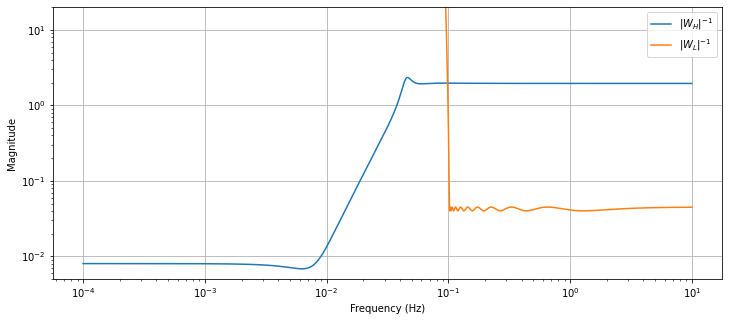

In [4]:
f = np.linspace(1e-4, 10 ,100000)
plt.figure(figsize=[12,5])
plt.loglog(f, abs(1/wH.horner(2*np.pi*1j*f)[0][0]), label='$|W_H|^{-1}$')
plt.loglog(f, abs(1/wL.horner(2*np.pi*1j*f)[0][0]), label='$|W_L|^{-1}$')
plt.ylim(5e-3, 2e1)
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend(loc=0)
# abs(wH.horner(2*np.pi*1j*f)[0][0])[-1]

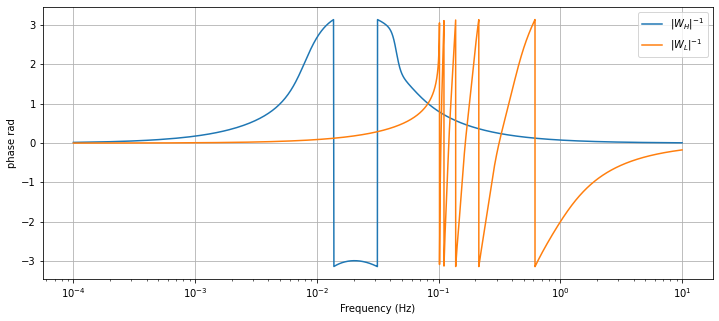

In [11]:
f = np.linspace(1e-4, 10 ,100000)
plt.figure(figsize=[12,5])
plt.semilogx(f, np.angle(1/wH.horner(2*np.pi*1j*f)[0][0]), label='$|W_H|^{-1}$')
plt.semilogx(f, np.angle(1/wL.horner(2*np.pi*1j*f)[0][0]), label='$|W_L|^{-1}$')
# plt.ylim(5e-3, 2e1)
plt.ylabel('phase rad')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend(loc=0)

In [5]:
P=[[tf([0],[1]), wL],[wH, -wH],[tf([1],[1]),tf([0],[1])]]
# tf(P)
aug_P_num = list(np.zeros_like(P))
aug_P_den = list(np.zeros_like(P))
for i in range(len(P)):
    for j in range(len(P[i])):
#         print(P[i][j])
        aug_P_num[i][j] = list(P[i][j].num[0][0])
        aug_P_den[i][j] = list(P[i][j].den[0][0])
    aug_P_num[i]=list(aug_P_num[i])
    aug_P_den[i]=list(aug_P_den[i])
aug_P=tf(aug_P_num, aug_P_den)
# plt.loglog(f, abs(aug_P.horner(2*pi*1j*f)[0][0]))
# plt.loglog(f, abs(wL.horner(2*pi*1j*f)[0][0]))
# aug_P.pole
# list(aug_P_num)
# wL.num[0][0]
# aug_P_num[0]
K, CL, gam, rcond=hinfsyn(ss(aug_P), 1, 1)

In [76]:
gam

1.2557048876315817

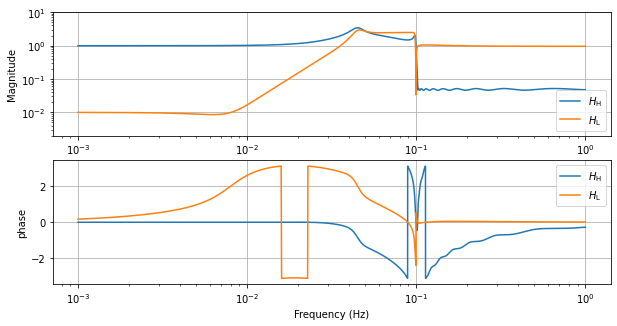

In [79]:
f = np.linspace(1e-3, 1 ,10000)

HH=ss2tf(K)
HL=1-HH
plt.figure(figsize=[10,5])
plt.subplot(211)
plt.loglog(f, abs(HH.horner(2*np.pi*1j*f)[0][0]), label='$H_\mathrm{H}$')
plt.loglog(f, abs(HL.horner(2*np.pi*1j*f)[0][0]), label='$H_\mathrm{L}$')
plt.ylim(2e-3, 10e0)
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend(loc=0)
plt.subplot(212)
# plt.figure(figsize=[12,5])
plt.semilogx(f, np.angle(HH.horner(2*np.pi*1j*f)[0][0]), label='$H_\mathrm{H}$')
plt.semilogx(f, np.angle(HL.horner(2*np.pi*1j*f)[0][0]), label='$H_\mathrm{L}$')
plt.ylabel('phase')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend(loc=0)

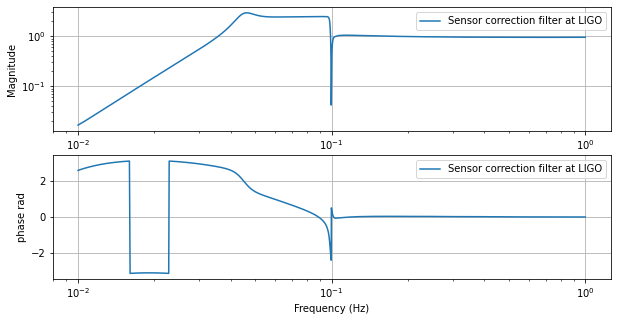

In [9]:
f = np.linspace(1e-2, 1 ,10000)

HH=ss2tf(K)
HL=1-HH
plt.figure(figsize=[10,5])
plt.subplot(211)
# plt.loglog(f, abs(HH.horner(2*np.pi*1j*f)[0][0]), label='$H_\mathrm{H}$')
plt.loglog(f, abs(HL.horner(2*np.pi*1j*f)[0][0]), label='Sensor correction filter at LIGO')
# plt.ylim(2e-3, 10e0)
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend(loc=0)
plt.subplot(212)
# plt.figure(figsize=[12,5])
# plt.semilogx(f, np.angle(HH.horner(2*np.pi*1j*f)[0][0]), label='$H_\mathrm{H}$')
plt.semilogx(f, np.angle(HL.horner(2*np.pi*1j*f)[0][0]), label='Sensor correction filter at LIGO')
plt.ylabel('phase rad')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend(loc=0)